In [1]:
import os
os.chdir("..")

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from helpers import load_config
import matplotlib.pyplot as plt
import seaborn as sns
from colorectal_adenocarcinoma.data_preprocessor import preprocess_data

configs = load_config(os.path.join("configs", "configs.yaml"))
study_path = configs["STORAGE_DIR_STUDY2"]

In [3]:
pathological_df = pd.read_csv(
    os.path.join(study_path, "pathological_df_v2.csv")
)
print(f"Shape of new pathological df:{pathological_df.shape}")
pathological_df.head(2)

Shape of new pathological df:(88, 18)


,PATIENT_ID,AGE,SEX,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,PERSON_NEOPLASM_CANCER_STATUS,PRIOR_DX,RADIATION_THERAPY,WEIGHT,PFS_MONTHS,GENETIC_ANCESTRY_LABEL,SAMPLE_ID,ONCOTREE_CODE,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS
0,TCGA-5M-AAT6,40.0,Female,M1A,N2B,T4A,With Tumor,No,No,99.1,7.199921,AFR,TCGA-5M-AAT6-01,COAD,3.0,0.6600,20.58,62.166667
1,TCGA-5M-AATE,76.0,Male,M0,N0,T3,With Tumor,No,No,75.4,26.629845,,TCGA-5M-AATE-01,COAD,20.0,0.3252,0.47,3.800000


In [8]:
df = pathological_df.copy()

In [9]:
def categorize_pfs(months):
    """categorize pfs into 3 classes at thresholds 12, 36, 36+"""
    if months <= 12:
        return 0
    elif 12 < months <= 36:
        return 1
    else:
        return 2


df['y'] = df['PFS_MONTHS'].apply(categorize_pfs)
df.head(2)

,PATIENT_ID,AGE,SEX,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,PERSON_NEOPLASM_CANCER_STATUS,PRIOR_DX,RADIATION_THERAPY,WEIGHT,PFS_MONTHS,GENETIC_ANCESTRY_LABEL,SAMPLE_ID,ONCOTREE_CODE,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS,y
0,TCGA-5M-AAT6,40.0,Female,M1A,N2B,T4A,With Tumor,No,No,99.1,7.199921,AFR,TCGA-5M-AAT6-01,COAD,3.0,0.6600,20.58,62.166667,0
1,TCGA-5M-AATE,76.0,Male,M0,N0,T3,With Tumor,No,No,75.4,26.629845,,TCGA-5M-AATE-01,COAD,20.0,0.3252,0.47,3.800000,1


In [21]:
X = df.drop(["SAMPLE_ID", "PATIENT_ID", "PFS_MONTHS", "y"], axis=1)
y = df.y
X.shape, y.shape

((88, 15), (88,))

In [22]:
X_preprocessed = preprocess_data(X)
X_preprocessed.shape

Label encoded PATH_M_STAGE
Label encoded PATH_N_STAGE
Label encoded PATH_T_STAGE


(88, 16)

In [16]:
from colorectal_adenocarcinoma.model_evaluators import multiclass_classification, plot_feature_importance_plot_using_rf

In [18]:
predictions = multiclass_classification(X_preprocessed, y, binary_classification=False)
pd.DataFrame(predictions).T.sort_values("F1-Score", ascending=False)


,F1-Score,Recall,Accuracy,Precision
K-Nearest Neighbors,0.453306,0.454406,0.454545,0.452381
Support Vector Machine,0.452381,0.453257,0.454545,0.460985
XGBoost,0.451997,0.452874,0.454545,0.452457
Random Forest,0.428197,0.429885,0.431818,0.439105
Linear SVM,0.411978,0.409195,0.409091,0.420592
Gradient Boosting,0.407527,0.407663,0.409091,0.416603
Logistic Regression,0.339102,0.340230,0.340909,0.338095
Decision Tree,0.336173,0.339464,0.340909,0.336398


In [25]:
X_preprocessed.sum().sort_values()

RADIATION_THERAPY_Yes                          4.000000
PRIOR_DX_Y                                     5.000000
ONCOTREE_CODE_MACR                             7.000000
ONCOTREE_CODE_READ                            20.000000
PERSON_NEOPLASM_CANCER_STATUS_With Tumor      30.000000
PATH_M_STAGE                                  31.500000
MSI_SCORE_MANTIS                              34.152900
SEX_Male                                      47.000000
GENETIC_ANCESTRY_LABEL                        61.000000
PATH_N_STAGE                                  75.980000
MSI_SENSOR_SCORE                             232.720000
PATH_T_STAGE                                 271.500000
TMB_NONSYNONYMOUS                            903.966667
ANEUPLOIDY_SCORE                            1273.000000
AGE                                         5417.000000
WEIGHT                                      7043.326000
dtype: float64

In [27]:
X2 = X_preprocessed.drop(["RADIATION_THERAPY_Yes", "PRIOR_DX_Y"], axis=1)

In [28]:
predictions = multiclass_classification(X2, y, binary_classification=False)
pd.DataFrame(predictions).T.sort_values("F1-Score", ascending=False)


,F1-Score,Recall,Accuracy,Precision
Random Forest,0.471014,0.475096,0.477273,0.472085
K-Nearest Neighbors,0.448486,0.454406,0.454545,0.449074
XGBoost,0.447633,0.452490,0.454545,0.446667
Support Vector Machine,0.436505,0.441379,0.443182,0.439946
Gradient Boosting,0.400640,0.396935,0.397727,0.410827
Linear SVM,0.365520,0.362835,0.363636,0.372948
Logistic Regression,0.336016,0.339847,0.340909,0.332920
Decision Tree,0.296880,0.304981,0.306818,0.298157


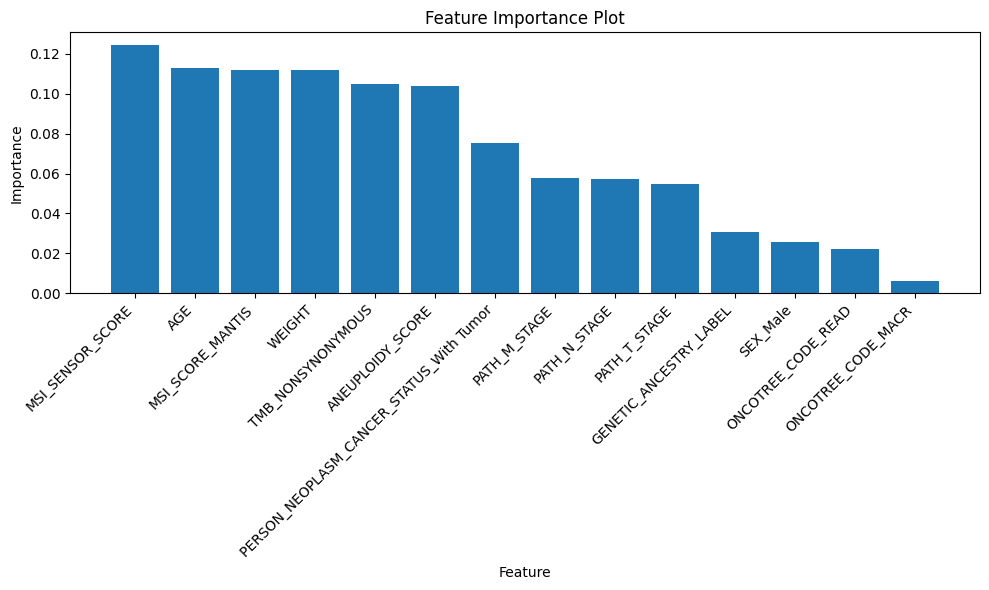

In [29]:
plot_feature_importance_plot_using_rf(X2, y)